## Entrenamiento con redes neuronales

---

### Modelo base

In [56]:
import pandas as pd
import numpy as np


In [57]:
# Importo los datos como dataframe de pandas
real = pd.read_csv("../Data/True.csv")
fake = pd.read_csv("../Data/Fake.csv")

In [58]:
# Mezclamos los 2 dataframes y los ramdomisamos el orden
from sklearn.utils import shuffle

news = real.append(fake, ignore_index=True)
news = shuffle(news)
news

,title,text,subject,date
42825,SAY WHAT? Tide Detergent Joins Forces With Ope...,I wish there was some way I could let Tide Det...,left-news,"Oct 17, 2015"
19775,U.S. Ambassador Haley: U.N. has exhausted opti...,WASHINGTON (Reuters) - U.S. Ambassador to the ...,worldnews,"September 17, 2017"
7524,Fox News poll shows Clinton leading Trump by 4...,WASHINGTON (Reuters) - Democrat Hillary Clinto...,politicsNews,"November 7, 2016"
2302,White House considers lower deduction for U.S....,WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"August 4, 2017"
641,Q&A: Did Sessions break the law by denying kno...,(Reuters) - U.S. Attorney General Jeff Session...,politicsNews,"November 14, 2017"
...,...,...,...,...
7887,Pressure on Trump likely to be intense at seco...,WASHINGTON (Reuters) - Republican presidentia...,politicsNews,"October 9, 2016"
5216,Trump intelligence nominee supports probes on ...,WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,"February 28, 2017"
11836,Desperate Venezuelans peddle wares door-to-doo...,"CUCUTA, Colombia (Reuters) - Thousands of impo...",worldnews,"December 20, 2017"
44423,BREAKING: Trump’s Travel Ban Halt Upheld by 9t...,21st Century Wire says Today the 9th Circuit C...,Middle-east,"February 9, 2017"


[Text(0, 0, 'left-news'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'politicsNews'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'News'),
 Text(5, 0, 'Government News'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

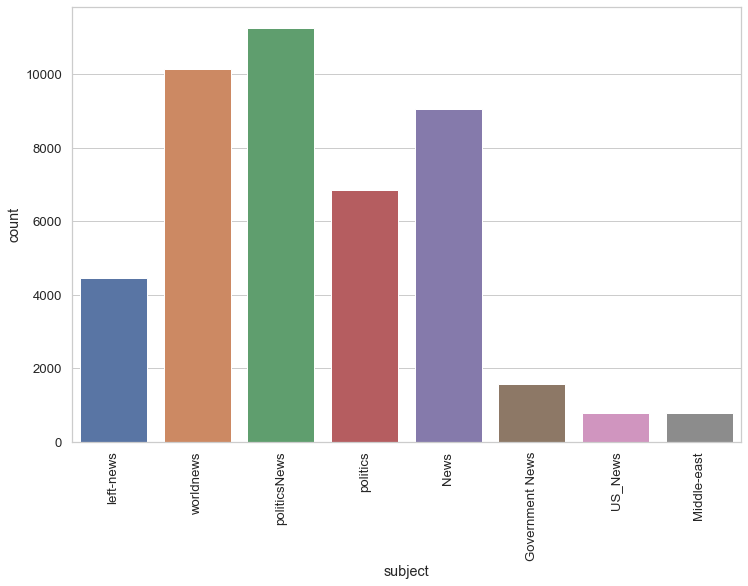

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", data = news)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

In [60]:
#Combinamos columnas de texto
news['text'] = news['title'] + " " + news['text']
news.drop(['title', 'date'], axis=1, inplace=True)
news.sample(5)

,text,subject
26498,Alabama Republican Governor BUSTED Lying To C...,News
16306,Vietnam dissident's daughter calls on Melania ...,worldnews
26427,You Really Don’t Want To Miss Ana Navarro PUM...,News
38354,95 YR OLD WWII VETERAN Writes Scathing Letter ...,Government News
1566,Ex-U.S. Rep. Weiner sentenced to 21 months in ...,politicsNews


In [61]:
news.shape

(44898, 2)

### Codificamos etiquetas

In [62]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
news['subject'] = le.fit_transform(news['subject'])
news['subject'].value_counts()

6    11272
7    10145
2     9050
5     6841
4     4459
0     1570
3      783
1      778
Name: subject, dtype: int64

### Separación de sets para entrenamiento, validación y testeo

In [63]:
# Se separan el dataset en los sets de train (luego el de train en validacion) y el de test
# este enfoque se justifica previo a la tokenizacion
from sklearn.model_selection import train_test_split

train, test = train_test_split(news, test_size=0.3, random_state=42, stratify=news['subject'])
train, validation = train_test_split(train, test_size = 0.2, random_state=42)
print(len(train), len(validation), len(test) )

25142 6286 13470


---

In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocabulario_max = 20000
filtrar = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' #Hay un problema con ' quizas se puede resolver en un paso previo

tokenizer = Tokenizer(num_words=vocabulario_max, filters=filtrar, lower=True, split=" ")
tokenizer.fit_on_texts(train.text)
word_index = tokenizer.word_index

In [65]:
# summarize what was learned
#print(tokenizer.word_counts)
#print(tokenizer.document_count)
#print(tokenizer.word_index)
#print(tokenizer.word_docs)

In [66]:
train_matrix = tokenizer.texts_to_matrix(np.array(train.text))
val_matrix = tokenizer.texts_to_matrix(np.array(validation.text))
test_matrix = tokenizer.texts_to_matrix(np.array(test.text))

In [67]:
type(train_matrix)

numpy.ndarray

In [68]:
train_matrix.shape

(25142, 20000)

In [69]:
train_matrix[0:2,:10]

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [70]:
val_matrix.shape

(6286, 20000)

In [71]:
test_matrix.shape

(13470, 20000)

In [72]:
x_train = np.copy(train_matrix)
x_val = np.copy(val_matrix)
x_test = np.copy(test_matrix)
y_train = train['subject'].values
y_val = validation['subject'].values
y_test = test['subject'].values


In [73]:
y_train

array([6, 6, 3, ..., 4, 4, 6])

In [74]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)
#y_test = to_categorical(y_test, num_classes=8)

y_train.shape, y_val.shape, y_test.shape

((25142, 8), (6286, 8), (13470,))

In [75]:
y_test

array([7, 6, 5, ..., 4, 2, 5])

### Aqui comienza la configuracion y entrenamiento de la red base

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Creamos un modelo con dos capas ocultas de 16 neuronas cada una
model = Sequential(name="modelo_base")
model.add(Dense(16, activation='relu', input_shape=(20000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='sigmoid'))

model.summary()

Model: "modelo_base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                320016    
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
Total params: 320,424
Trainable params: 320,424
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Compilamos el modelo
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [78]:
# Entrenamos
history = model.fit(x=x_train, y=y_train,
                    epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
50/50 [==============================] - 8s 164ms/step - loss: 1.3140 - accuracy: 0.6624 - val_loss: 0.9192 - val_accuracy: 0.7240
Epoch 2/20
50/50 [==============================] - 4s 83ms/step - loss: 0.7066 - accuracy: 0.8001 - val_loss: 0.6793 - val_accuracy: 0.8035
Epoch 3/20
50/50 [==============================] - 3s 52ms/step - loss: 0.4857 - accuracy: 0.8390 - val_loss: 0.5484 - val_accuracy: 0.7949
Epoch 4/20
50/50 [==============================] - 2s 48ms/step - loss: 0.3805 - accuracy: 0.8568 - val_loss: 0.4944 - val_accuracy: 0.7892
Epoch 5/20
50/50 [==============================] - 2s 45ms/step - loss: 0.3197 - accuracy: 0.8722 - val_loss: 0.4720 - val_accuracy: 0.7927
Epoch 6/20
50/50 [==============================] - 2s 40ms/step - loss: 0.2848 - accuracy: 0.8785 - val_loss: 0.4773 - val_accuracy: 0.7870
Epoch 7/20
50/50 [==============================] - 2s 38ms/step - loss: 0.2606 - accuracy: 0.8857 - val_loss: 0.4818 - val_accuracy: 0.7929
Epoch 8/20
5

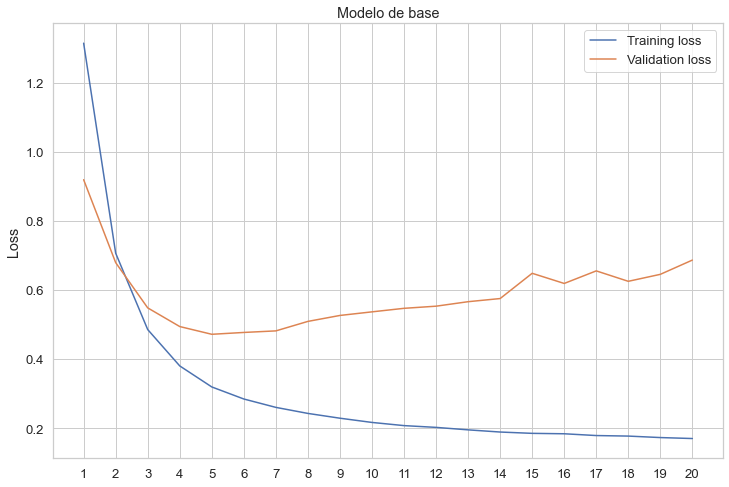

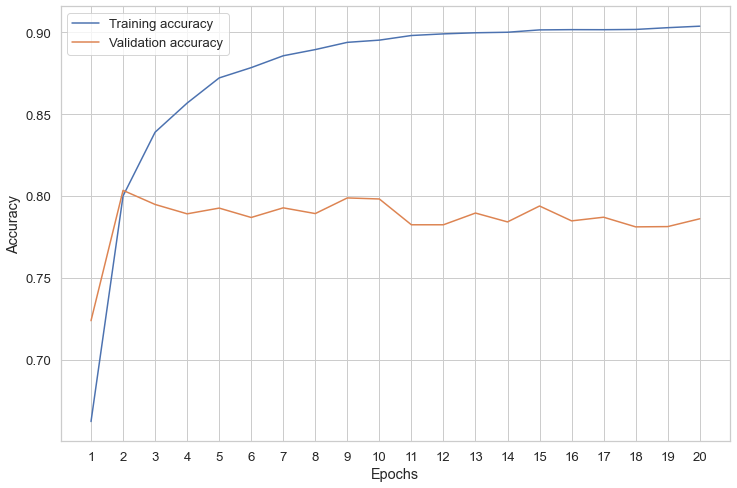

In [79]:
import matplotlib.pyplot as plt
# El atributo `history` contiene un diccionario de métricas por epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.title('Modelo de base')
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.xticks(ticks=epochs)
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.figure(figsize=(12,8))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xticks(ticks=list(epochs))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy']);

### Testeo

In [80]:
y_pred = model.predict_classes(x_test)

In [81]:
y_pred.shape, y_test.shape

((13470,), (13470,))

In [82]:
y_pred

array([7, 6, 4, ..., 5, 2, 4])

In [83]:
y_test

array([7, 6, 5, ..., 4, 2, 5])

In [84]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.06      0.08       471
           1       0.12      0.08      0.10       233
           2       0.99      0.99      0.99      2715
           3       0.30      0.36      0.33       235
           4       0.13      0.08      0.10      1338
           5       0.44      0.62      0.52      2052
           6       0.99      0.98      0.98      3382
           7       0.98      0.98      0.98      3044

    accuracy                           0.78     13470
   macro avg       0.51      0.52      0.51     13470
weighted avg       0.76      0.78      0.77     13470



In [85]:
cm = confusion_matrix(y_test, y_pred)


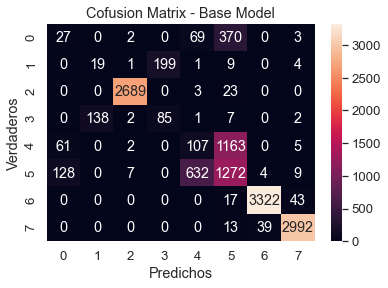

In [86]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='.0f')
plt.ylabel('Verdaderos')
plt.title('Cofusion Matrix - Base Model')
plt.xlabel('Predichos');